# Wilcoxon Signed-Rank Test

> Use Case:
- The Wilcoxon Signed Rank Test is commonly used when you have paired data or two related groups and you want to determine if there is a significant difference between their distributions. 
- It is a non-parametric test that assesses whether the distribution of differences between paired observations is symmetric around zero.
- This test is particularly useful when the data does not meet the assumptions of a parametric test or when you are interested in the central tendency of the differences rather than their mean.
> Assumptions:
- The data is at least at the ordinal scale.
- The differences between paired observations are independent.
- The null hypothesis assumes that the median of the differences is zero.
> Example Scenario:
- Consider a scenario where you are testing the effectiveness of a new training program. You collect data on the performance scores of individuals before and after the training. You want to determine if there is a significant difference in the performance scores after the training.
> Null Hypothesis (H0):
- There is no significant difference in the distribution of differences between paired observations; the median of the population of differences is zero.
> Alternative Hypothesis (H1):
- There is a significant difference in the distribution of differences between paired observations; the median of the population of differences is not zero.

In [444]:
import warnings

warnings.filterwarnings("ignore")

In [445]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import statsmodels.stats.power as smp

# !pip install scipy==1.12.0
from scipy.stats import skewtest, wilcoxon

# !pip install pingouin==0.5.5
import pingouin as pg

In [446]:
# Set random seed for reproducibility
np.random.seed(42)

In [447]:
# set seaborn style
sns.set(style="white", palette="mako")

# colors
color = 'blue'

# remove some borders    
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

### Power Analysis

In [448]:
def calculate_wilcoxon_signed_rank_sample_size(effect_size, alpha=0.05, power=0.8, alternative='two-sided'):
    """
    Calculates the approximate sample size needed for a Wilcoxon Signed-Rank test.
    
    Args:
        effect_size (float): A standardized effect size for the differences.
                            Cohen's d for paired samples is often used here.
                            A rough guideline: small=0.2, medium=0.5, large=0.8.
                            This represents the standardized mean difference you expect
                            to detect in the population of differences.
        alpha (float, optional): Significance level (Type I error rate). Defaults to 0.05.
        power (float, optional): Desired power of the test (1 - Type II error rate). Defaults to 0.8.
        alternative (str, optional): 'two-sided' or 'one-sided'. Defaults to 'two-sided'.

    Returns:
        int: The approximate sample size (number of pairs) needed.
            Returns None if the power analysis fails.
    """

    if alternative not in ['two-sided', 'one-sided']:
        raise ValueError("Alternative must be 'two-sided' or 'one-sided'")

    # TTestPower is used for one-sample t-test by setting ratio=0
    # This approximates the paired t-test, which is often used as a proxy
    # for Wilcoxon Signed-Rank power analysis.
    analysis = smp.TTestPower()
    n = analysis.solve_power(effect_size=effect_size,
                            alpha=alpha,
                            power=power,
                            nobs=None,  # We are solving for nobs (sample size)
                            alternative=alternative)

    if n is not None:
        return int(np.ceil(n))
    else:
        return None

In [449]:
alpha_level = 0.05
desired_power = 0.8

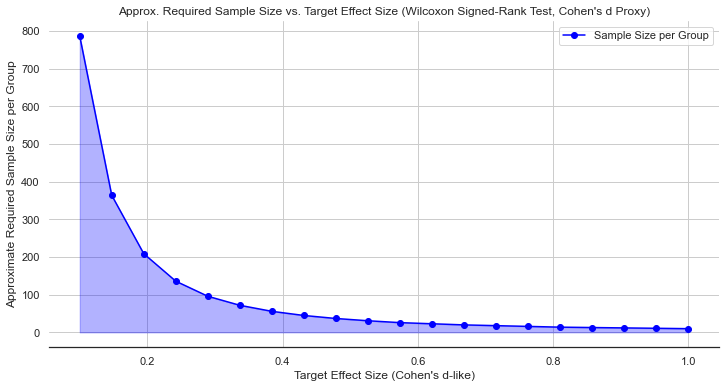

In [450]:
# Define a range of effect sizes to explore
effect_sizes = np.linspace(0.1, 1.0, 20) # From small to large effect sizes

# Initialize an empty list to store the calculated sample sizes
sample_sizes = []

# Iterate over the effect sizes and calculate the required sample size for each
for effect in effect_sizes:
    n = calculate_wilcoxon_signed_rank_sample_size(
        effect_size=effect,
        alpha=alpha_level,
        power=desired_power,
    )
    if n is not None:
        sample_sizes.append(n)
    else:
        sample_sizes.append(np.nan) # Append NaN if calculation fails

# Plot the effect sizes against the required sample sizes
plt.figure(figsize=(12, 6))
plt.plot(effect_sizes, sample_sizes, marker='o', linestyle='-', color=color, label='Sample Size per Group')
plt.fill_between(effect_sizes, sample_sizes, color=color, alpha=0.3)
plt.title('Approx. Required Sample Size vs. Target Effect Size (Wilcoxon Signed-Rank Test, Cohen\'s d Proxy)')
plt.xlabel('Target Effect Size (Cohen\'s d-like)')
plt.ylabel('Approximate Required Sample Size per Group')
plt.grid(True)
plt.legend()
plt.show()

In [451]:
# Let's say we anticipate a small effect size (Cohen's d = 0.2)
effect = 0.2

sample_size_per_group = calculate_wilcoxon_signed_rank_sample_size(
    effect_size=effect,
    alpha=alpha_level,
    power=desired_power,
)
print(f"Approximate sample size needed per group: {sample_size_per_group}")

Approximate sample size needed per group: 199


### Synthetic Data

In [452]:
# Skew Component
skewness = 3
# Max
max_value = 100

# Generate synthetic data for Wilcoxon Signed Rank Test
before_training = np.random.normal(loc=50, scale=10, size=sample_size_per_group)
before_training = np.clip(before_training, 0, max_value)

# Exponential Skew Component
skew_component = np.random.exponential(scale=skewness * 5, size=sample_size_per_group)
# Subtract mean of exponential for centering
after_training = before_training + np.random.normal(loc=5, scale=1, size=sample_size_per_group) + skew_component - (skewness * 2.5) 
after_training = np.clip(after_training, 0, max_value)

# Create pandas DataFrame
wilcoxon_data = pd.DataFrame({'Before Training': before_training, 'After Training': after_training})
wilcoxon_data


,Before Training,After Training
0,54.967142,82.803301
1,48.617357,66.860557
2,56.476885,71.976875
3,65.230299,79.469002
4,47.658466,50.996714
...,...,...
194,51.731809,52.534914
195,53.853174,51.480296
196,41.161426,39.504190
197,51.537251,64.920506


### Assumptions

In [453]:
def check_wilcoxon_assumptions(data_before, data_after):
    """
    Checks the assumption of symmetry for the differences in paired data,
    which is important for the Wilcoxon Signed-Rank test.

    Args:
        data_before (array-like): Measurements from the first condition (e.g., 'before').
        data_after (array-like): Measurements from the second condition (e.g., 'after'),
                                paired with data_before.

    Returns:
        None: Prints observations and displays plots.
    """
    if len(data_before) != len(data_after):
        print("Error: Input arrays must have the same length for paired data.")
        return

    # Calculate the differences
    differences = np.array(data_after) - np.array(data_before)
    print(f"Number of paired observations: {len(differences)}")
    print(f"Median of differences: {np.median(differences):.3f}")

    # Perform D'Agostino's K-squared test for skewness
    # Null hypothesis (H0): The sample comes from a population with zero skewness.
    # A small p-value (e.g., < 0.05) suggests significant skewness.
    stat, p_value = skewtest(differences)
    print(f"\nD'Agostino's K-squared test for skewness:")
    print(f"  Statistic: {stat:.3f}")
    print(f"  P-value: {p_value:.3f}")

    if p_value < 0.05:
        print("  Interpretation: The p-value is less than 0.05, suggesting significant skewness.")
        print("  This indicates a potential violation of the symmetry assumption for the Wilcoxon Signed-Rank test.")
    else:
        print("  Interpretation: The p-value is greater than or equal to 0.05, suggesting no significant skewness.")
        print("  This supports the symmetry assumption for the Wilcoxon Signed-Rank test.")

In [454]:
check_wilcoxon_assumptions(before_training, after_training)

Number of paired observations: 199
Median of differences: 8.395

D'Agostino's K-squared test for skewness:
  Statistic: 5.974
  P-value: 0.000
  Interpretation: The p-value is less than 0.05, suggesting significant skewness.
  This indicates a potential violation of the symmetry assumption for the Wilcoxon Signed-Rank test.


### Wilcoxon Signed-Rank Test (SciPy)

In [467]:
# Function to run Wilcoxon Signed Rank Test
def run_wilcoxon_signed_rank_test(data):
    # Calculate the differences between paired observations
    differences = data['After Training'] - data['Before Training']
    
    # Run Wilcoxon Signed Rank Test
    stat, p_value = wilcoxon(differences)
    
    print(f'Wilcoxon Signed Rank Test: Statistic={stat}, p-value={p_value}')

    # Interpret the results
    alpha = 0.05
    if p_value < alpha:
        print('\nReject the null hypothesis: \nThere is a significant difference in the distribution of differences.')
    else:
        print('\nFail to reject the null hypothesis: \nThere is no significant difference in the distribution of differences.')

# Example usage for Wilcoxon data
run_wilcoxon_signed_rank_test(wilcoxon_data)

Wilcoxon Signed Rank Test: Statistic=1172.0, p-value=3.784551084880872e-27

Reject the null hypothesis: 
There is a significant difference in the distribution of differences.


### Wilcoxon Signed-Rank Test (pingouin)

In [465]:
def run_wilcoxon_signed_rank_test_pingouin(data_before, data_after, alternative='two-sided'):
    """
    Runs the Wilcoxon Signed-Rank Test using the pingouin package.

    Args:
        data_before (array-like): Measurements from the first condition (e.g., 'before').
        data_after (array-like): Measurements from the second condition (e.g., 'after'),
                                paired with data_before.
        alternative (str, optional): Defines the alternative hypothesis.
                                    Can be 'two-sided', 'greater', or 'less'.
                                    Defaults to 'two-sided'.

    Returns:
        pandas.DataFrame: A DataFrame containing the test results (W-statistic, p-value,
                        effect size, confidence interval, etc.).
    """
    if len(data_before) != len(data_after):
        print("Error: Input arrays must have the same length for paired data.")
        return None

    # Pingouin's wilcoxon function directly accepts the two paired arrays.
    # It automatically calculates the differences internally.
    results = pg.wilcoxon(x=data_after, y=data_before, alternative=alternative, method='auto')

    display(results)

    # Interpret the results
    alpha = 0.05
    p_value = results['p-val'].iloc[0] # Extract p-value from the DataFrame

    print(f'\nInterpretation (alpha={alpha}):')
    if p_value < alpha:
        print('  Reject the null hypothesis: There is a significant difference between the two paired conditions.')
    else:
        print('  Fail to reject the null hypothesis: There is no significant difference between the two paired conditions.')

    print(f"\nNotes: The 'W-val' is the Wilcoxon W statistic. 'p-val' is the p-value.")
    print(f"      'RBC' is the Rank-Biserial Correlation effect size.")
    print(f"      'CLES' Common Language Effect Size ")

    return results

In [466]:
# Running Wilcoxon Signed-Rank Test with Pingouin
wilcoxon_results_pingouin = run_wilcoxon_signed_rank_test_pingouin(
                                                                    data_before=before_training,
                                                                    data_after=after_training,
                                                                    alternative='two-sided'
                                                                )

,W-val,alternative,p-val,RBC,CLES
Wilcoxon,1172.0,two-sided,3.809951e-27,0.882211,0.730891



Interpretation (alpha=0.05):
  Reject the null hypothesis: There is a significant difference between the two paired conditions.

Notes: The 'W-val' is the Wilcoxon W statistic. 'p-val' is the p-value.
      'RBC' is the Rank-Biserial Correlation effect size.
      'CLES' Common Language Effect Size 


### Confidence Intervals

In [458]:
alpha = 0.05
n_boot = 1000

# Compute Bootstrapped Confidence Interval for the Median Difference 
differences = np.array(after_training) - np.array(before_training)
median_diff = round((np.median(after_training - before_training)), 2)
print(f"The Median Difference between groups is {median_diff}")

if np.count_nonzero(differences) == 0:
    print("\nWarning: All differences are zero. Cannot compute a meaningful confidence interval.")
    boot_ci = None
else:
    try:
        boot_ci = pg.compute_bootci(differences, func=np.median, n_boot=n_boot, paired=True, confidence=1-alpha)
        print(f"\nBootstrapped {100*(1-alpha)}% Confidence Interval for Median Difference: {boot_ci}")
    except Exception as e:
        print(f"\nAn error occurred while computing bootstrapped CI: {e}")
        boot_ci = None

The Median Difference between groups is 8.39

Bootstrapped 95.0% Confidence Interval for Median Difference: [ 5.91 11.24]


### Visualization

In [459]:
# Count everything up
total_count = wilcoxon_data.size
group_a_count = wilcoxon_data['Before Training'].count()
group_b_count = wilcoxon_data['After Training'].count()
group_a_median = wilcoxon_data['Before Training'].median()
group_b_median = wilcoxon_data['After Training'].median()
group_a_var= wilcoxon_data['Before Training'].var()
group_b_var = wilcoxon_data['After Training'].var()
group_a_std= wilcoxon_data['Before Training'].std()
group_b_std = wilcoxon_data['After Training'].std()

In [460]:
# Create a new DataFrame for plotting
plot_data = pd.DataFrame({
    'Test Group': ["Before Training", "After Training"],
    'Total': [group_a_count, group_b_count],
    'Median Performance Scores': [group_a_median, group_b_median],
    'Variance': [group_a_var, group_b_var],
    'Standard Deviation': [group_a_std, group_b_std],
}, index=[0, 1])
plot_data

,Test Group,Total,Median Performance Scores,Variance,Standard Deviation
0,Before Training,199,50.051135,86.497950,9.300427
1,After Training,199,58.957124,237.242512,15.402679


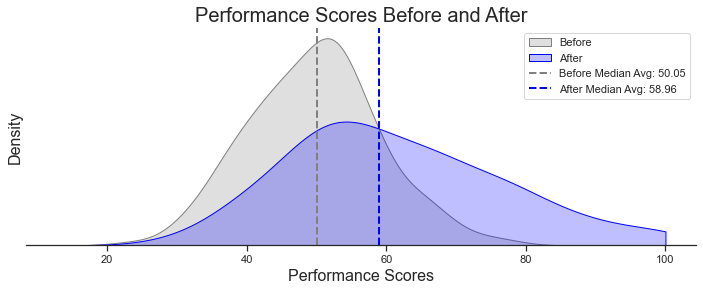

In [470]:
# Compare distributions of medians between the observations
plt.figure(figsize=(12, 4))
sns.kdeplot(wilcoxon_data['Before Training'], label='Before', fill = True, color = 'grey', clip = (0, 100))
sns.kdeplot(wilcoxon_data['After Training'], label='After', fill = True, color = color, clip = (0, 100))
median_group_a = wilcoxon_data['Before Training'].median()
median_group_b = wilcoxon_data['After Training'].median()
plt.axvline(median_group_a, color='grey', linestyle='dashed', linewidth=2, label=f'Before Median Avg: {median_group_a:.2f}')
plt.axvline(median_group_b, color=color, linestyle='dashed', linewidth=2, label=f'After Median Avg: {median_group_b:.2f}')
plt.title('Performance Scores Before and After', fontsize = 20)
plt.xlabel('Performance Scores', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.tick_params(left=False,bottom=True,labelleft=False,labelbottom=True)
plt.legend()
plt.show()